In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

from sklearn import metrics
import sklearn.metrics as mt
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

import sys
sys.path.append(parent_dir)

import balanceDataset as balance
import modelTrainingAndPerformance as mtap

import shap

## Dataset Description

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- amount - amount of the transaction in local currency.
- nameOrig - customer who started the transaction
- oldbalanceOrg - initial balance before the transaction
- newbalanceOrig - new balance after the transaction
- nameDest - customer who is the recipient of the transaction
- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
data = pd.read_csv('paysim.csv')
df = data.copy()

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
 df.duplicated().sum()

0

In [8]:
#df = df.drop(columns = ['step', 'isFlaggedFraud'], axis = 'columns') #gereksiz sütunları çıkardık

In [9]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [10]:
#fig = px.box(df, y="amount")
#fig.show()

## EDA

In [11]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [12]:
# İşlemlerin yapıldığı kaynağın kontrol edilmesi.
transfer_df = df[((df['type']=='TRANSFER') & df['isFraud']==1)] 
transfer_df['nameOrig'].value_counts()

C1305486145    1
C202278158     1
C12585107      1
C946427395     1
C1069177491    1
              ..
C2090764492    1
C1794935564    1
C318078280     1
C939293281     1
C1685995037    1
Name: nameOrig, Length: 4097, dtype: int64

In [13]:
# İşlemlerin nakde çevrildiği varış noktasının kontrol edilmesi.
cash_out_fraud = df[(df['type'] == 'CASH_OUT') & (df['isFraud'] == 1)]
cash_out_fraud['nameDest'].value_counts()

C200064275     2
C1399829166    2
C1650668671    2
C2129197098    2
C1013511446    2
              ..
C1566713324    1
C1955464150    1
C1104137869    1
C377165949     1
C873221189     1
Name: nameDest, Length: 4091, dtype: int64

In [14]:
fraud_trans = df[df['isFraud'] == 1]
valid_trans = df[df['isFraud'] == 0]

trans_transfer = df[df['type'] == 'TRANSER']
trans_cashout = df[df['type'] == 'CASH_OUT']

print('Nakit çekmek için kullanılan alıcı hesabı var mı?')
trans_transfer.nameDest.isin(trans_cashout.nameOrig).any()

Nakit çekmek için kullanılan alıcı hesabı var mı?


False

plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True);

sns.violinplot(x = df['isFraud'],y = df['amount']);

sns.violinplot(x = df['isFraud'],y = df[df['oldbalanceOrg']<100000].oldbalanceOrg);

sns.boxplot(x=df.isFraud,y=df.step);

plt.figure(figsize=(10,8))
plt.pie(df.type.value_counts().values,labels=df.type.value_counts().index,  autopct='%.0f%%')
plt.title("Transaction Type")
plt.show()

from sklearn.preprocessing import LabelEncoder
encoder = {}
for i in df.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    df[i] = encoder[i].fit_transform(df[i])

In [15]:
df=pd.concat([df,pd.get_dummies(df['type'], prefix='type_')],axis=1)
df.drop(['type'],axis=1,inplace = True)

df.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


## Sonuçlar

* Dolandırıcılık işlemlerimiz TRANSFER ve CASH_OUT işlem tipinde yapılmaktadır.

* TRANSFER'deki dolandırıcılık işlemleri 4097 ve CASH_OUT 4116 adet.

* Dolandırıcılık işlemleri genellikle Müşteriden Müşteriye yapılmakta.

* Alım ve Gönderim için kullanılan işlem hesabı, Dolandırıcılık işlemlerinde Aynı değil.

## Preprocessing

In [43]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns.size

8

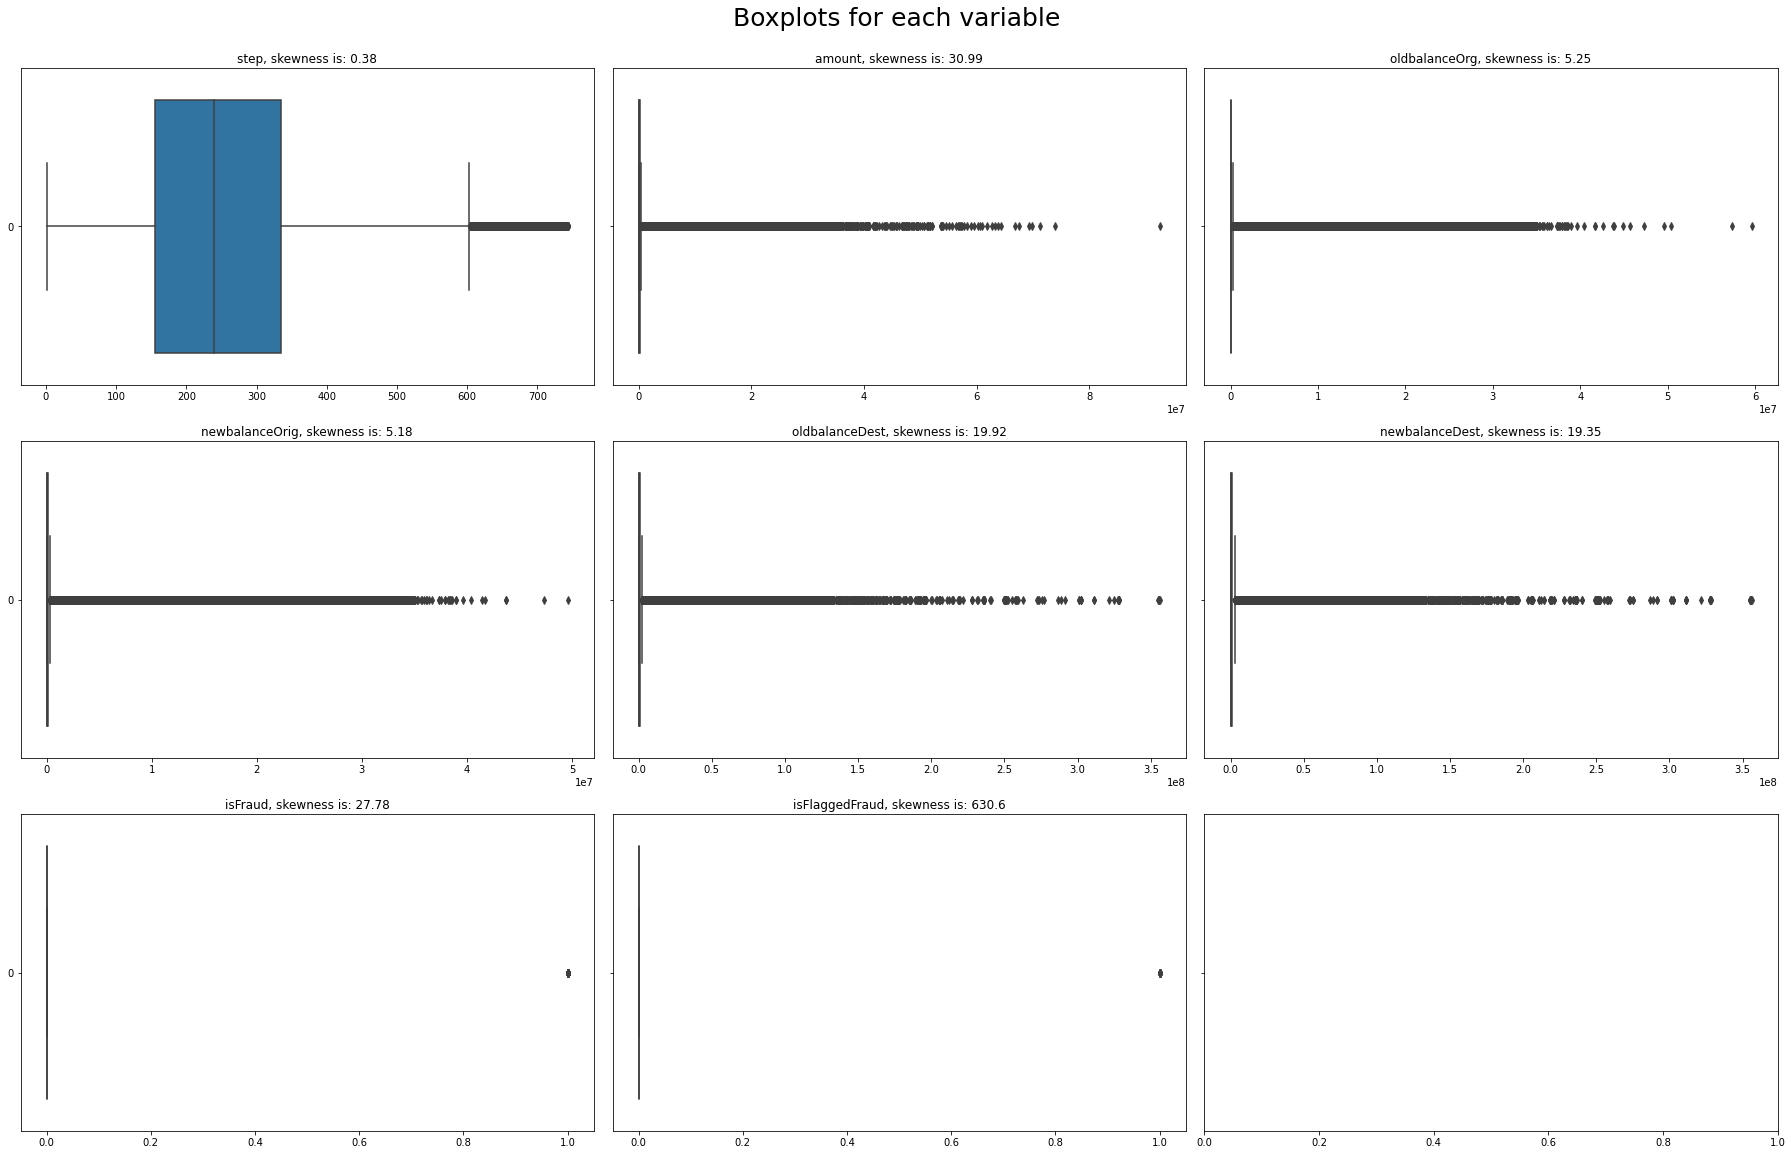

In [50]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(25,16))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=int(numeric_columns.size/3)+1, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

## Feature Engineering (chi2, ANNOVA)

### ...

## Model Oluşturma

In [16]:
#df.drop(columns=['type','nameOrig','nameDest'], inplace=True)
df.drop(columns=['nameOrig','nameDest'], inplace=True)

In [17]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [18]:
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [20]:
#X_train, X_test, y_train, y_test = train_test_split(X_chi2, y, test_size = 0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, stratify=y)

In [21]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
X_train_ros, y_train_ros = balance.balancedWithRandomOverSampler(X_train,y_train)

Non-Frauds: 4448085 / 50.0 % of the dataset
Frauds: 4448085 / 50.0 % of the dataset


In [23]:
X_train_rus, y_train_rus = balance.balancedWithRandomUnderSampler(X_train,y_train)

Non-Frauds: 5749 / 50.0 % of the dataset
Frauds: 5749 / 50.0 % of the dataset


In [24]:
X_train_smote, y_train_smote = balance.balanceWithSMOTE(X_train, y_train)

Non-Frauds: 4448085 / 50.0 % of the dataset
Frauds: 4448085 / 50.0 % of the dataset


In [25]:
params = {
    'n_estimators': 100,
    'n_jobs': -1
}

ml_models = [ lgb.LGBMClassifier(**params)
             , XGBClassifier(**params)] 
             #, AdaBoostClassifier()
             #,GradientBoostingClassifier(),CatBoostClassifier()]

In [27]:
for i in ml_models:
    mtap.model_performance(i, X_train, X_test, y_train, y_test, "baseline")
    mtap.model_performance(i, X_train_ros, X_test, y_train_ros, y_test, "RandomOverSampler")
    mtap.model_performance(i, X_train_rus, X_test, y_train_rus, y_test, "RandomUnderSampler")
    mtap.model_performance(i, X_train_smote, X_test, y_train_smote, y_test, "SMOTE")

***** LGBMClassifier_baseline DONE *****
***** LGBMClassifier_RandomOverSampler DONE *****
***** LGBMClassifier_RandomUnderSampler DONE *****
***** LGBMClassifier_SMOTE DONE *****


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:55:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_baseline DONE *****


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:58:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_RandomOverSampler DONE *****


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:06:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_RandomUnderSampler DONE *****


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:06:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_SMOTE DONE *****


In [30]:
mtap.all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,precision,recall,f1_score,AUC
4,XGBClassifier_baseline,0.966884,0.841315,0.899740,0.920639
5,XGBClassifier_RandomOverSampler,0.463051,0.984172,0.629788,0.991348
7,XGBClassifier_SMOTE,0.333516,0.989448,0.498875,0.993446
0,LGBMClassifier_baseline,0.544065,0.433442,0.482494,0.716486
1,LGBMClassifier_RandomOverSampler,0.254527,0.992695,0.405168,0.994468
3,LGBMClassifier_SMOTE,0.203891,0.991071,0.338204,0.993035
2,LGBMClassifier_RandomUnderSampler,0.137572,0.997565,0.241798,0.994741
6,XGBClassifier_RandomUnderSampler,0.120459,0.997159,0.214951,0.993874


In [53]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [54]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}

grid_rf = GridSearchCV(lgb.LGBMClassifier(**params), param_grid=params,
                       cv=kf, scoring='recall').fit(X_train, y_train)

In [55]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 12, 'n_estimators': 50, 'random_state': 13}
Best score: 0.5141818594619139


In [ ]:
y_pred = grid_rf.predict(X_test)


In [33]:
params = {
    'n_estimators': 100,
    'n_jobs': 3
}

ml_models = [ lgb.LGBMClassifier(**params)
             , XGBClassifier(**params)] 
             #, AdaBoostClassifier()
             #,GradientBoostingClassifier(),CatBoostClassifier()]

In [34]:
for i in ml_models:
    mtap.model_performance(i, X_train, X_test, y_train, y_test, "baseline")
    mtap.model_performance(i, X_train_ros, X_test, y_train_ros, y_test, "RandomOverSampler")
    mtap.model_performance(i, X_train_rus, X_test, y_train_rus, y_test, "RandomUnderSampler")
    mtap.model_performance(i, X_train_smote, X_test, y_train_smote, y_test, "SMOTE")

***** LGBMClassifier_baseline DONE *****
***** LGBMClassifier_RandomOverSampler DONE *****
***** LGBMClassifier_RandomUnderSampler DONE *****
***** LGBMClassifier_SMOTE DONE *****


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:19:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_baseline DONE *****


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_RandomOverSampler DONE *****


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_RandomUnderSampler DONE *****


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[12:34:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***** XGBClassifier_SMOTE DONE *****


In [35]:
mtap.all_performances.sort_values(by=['f1_score'], ascending=False)

,model_name,precision,recall,f1_score,AUC
4,XGBClassifier_baseline,0.966884,0.841315,0.899740,0.920639
5,XGBClassifier_RandomOverSampler,0.463051,0.984172,0.629788,0.991348
8,LGBMClassifier_baseline,0.585628,0.552354,0.568505,0.775924
7,XGBClassifier_SMOTE,0.333516,0.989448,0.498875,0.993446
0,LGBMClassifier_baseline,0.544065,0.433442,0.482494,0.716486
1,LGBMClassifier_RandomOverSampler,0.254527,0.992695,0.405168,0.994468
3,LGBMClassifier_SMOTE,0.203891,0.991071,0.338204,0.993035
2,LGBMClassifier_RandomUnderSampler,0.137572,0.997565,0.241798,0.994741
6,XGBClassifier_RandomUnderSampler,0.120459,0.997159,0.214951,0.993874


### Feature selection with correlation-matrix

corr_matrix = df.corr()
corr_matrix

corr_threshold = 0.2 or -0.2

# Select highly correlated features
#high_corr_features = corr_matrix[abs(corr_matrix['isFraud']) > corr_threshold]['isFraud'].index.tolist()



for i in df.columns:
    high_corr_features = corr_matrix[abs(corr_matrix[i]) > corr_threshold].index.tolist()
    print(high_corr_features)

df_selected = df[high_corr_features + ['isFraud']]
df_selected

plt.figure(figsize=(10,5)) 
sns.heatmap(df.corr(),annot=True);

X = df_selected.drop('isFraud', axis=1)
y = df_selected['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

for i in ml_models:
    function.model_performance(i, X_train, X_test, y_train, y_test, "baseline_corr")

function.all_performances.sort_values(by=['f1_score'], ascending=False)